In [1]:
# import time
import os
from os import path
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
from IPython.display import Audio, display
#from pydub import AudioSegment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

from torchaudio import transforms
from torchvision import transforms as T
import torchvision.models as models
from torchsummary import summary

from pytorch_pretrained_vit import ViT
from pytorch_pretrained_vit.configs import PRETRAINED_MODELS

import soundfile as sf
import librosa
from tqdm.notebook import tqdm

from utils import * 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torchaudio.__version__)




C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


1.8.1
0.8.1


In [2]:
!nvidia-smi 

Sat Apr 10 18:36:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P8    10W /  N/A |    768MiB /  6144MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

# panda time

In [3]:
tracks = pd.read_csv('data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
subset=tracks.index[tracks['set', 'subset'] == 'small']
tracks=tracks.loc[subset]
tracks;

## split dataset (train, test) + preprocess mono/multi classification

In [4]:
# train => track_id train 
# data => track_id + label
train_index = tracks.index[tracks['set', 'split'] == 'training']
val_index = tracks.index[tracks['set', 'split'] == 'validation']
test_index = tracks.index[(tracks['set', 'split'] == 'test' )| (tracks['set', 'split']=='validation') ]
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train_index, val_index, test_index])))
genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
print('Top genres ({}): {}'.format(len(genres), genres))
data=tracks['track', 'genre_top']
# data,train_index[0], data.loc[train_index[0]] # (2, 'Hip-Hop')
# pour multi classifier
multi_classifier=False
if multi_classifier:
    enc = MultiLabelBinarizer()
    labels = tracks['track', 'genres_all']
    test_multi_index = tracks.index[(tracks['set', 'split'] == 'test' ) ]

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train_index])
    y_val = enc.transform(labels[val_index])
    y_test = enc.transform(labels[test_index])
    
# /!\ data corrupted delete them : "099134.mp3" "108925.mp3" "133297.mp3" use cell below    
flag=len(train_index)
for i in range(len(train_index)):
    if flag==i:
        break
    if str(train_index[i])=="99134" or str(train_index[i])=="108925" or str(train_index[i])=="133297":
        print("indice data corrupted =",i)
        train_index=train_index.delete(i)
        if multi_classifier:
            y_train=np.delete(y_train, i,axis=0)

        flag=flag-1

6400 training examples, 800 validation examples, 1600 testing examples
Top genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
indice data corrupted = 3530
indice data corrupted = 3896
indice data corrupted = 5609


## (use one time) to convert all mp3 to wav (speed load mp3 << speed load wav) with downsample from 44100 to 22050 Hz

#!mkdir "data_proces/fma_small/"
path1="data/fma_small/"
path_stockage="data_proces/fma_small/"
count=0
for root, dirs, files in os.walk(path1):
    for name in files:
        if name.endswith(".mp3"):
            if not(path.exists(path_stockage+name[:-4]+'.wav')):
                try:
                    waveform, sample_rate=librosa.load(root+"/"+name,duration=15,sr=22050)
                    sf.write(path_stockage+name[:-4]+'.wav', waveform, sample_rate)
                    count+=1
                except:
                    print("audio :"+root+"/"+name+"  is corrupted")

# transformer
https://colab.research.google.com/drive/1muZ4QFgVfwALgqmrfOkp7trAvqDemckO?usp=sharing#scrollTo=sb13T_M0yFb1
https://colab.research.google.com/github/ra1ph2/Vision-Transformer/blob/main/VisionTransformer.ipynb

In [5]:
#!pip install --upgrade pytorch-pretrained-vit

## model

In [ ]:
#Pretrained on ImageNet-21k and fine tune on ImageNet-1k 
model_name = 'B_16_imagenet1k' #86859496
model_name = "B_32_imagenet1k" #88297192
model_name = "B_32_imagenet1k" #88297192
model_name ="L_16_imagenet1k" #304 715 752
model_name ="L_32_imagenet1k" #306 632 680
# just trained on ImageNet-21k
model_name ="L_32" #327 899 475
model_name ="B_16" #102 595 923
model_name ="B_32" #104 252 499
model_name ="L_16" # pretraine param not avaiable
model_name ="L_32" #327 899 475
# count_parameters(model)
all_model_pretrained=['B_16', 'B_32', 'L_32', 'B_16_imagenet1k', 'B_32_imagenet1k', 'L_16_imagenet1k', 'L_32_imagenet1k']

In [6]:
from model import *

class Perso_ViT(nn.Module):
    def __init__(self,name_model="B_16_imagenet1k",PRETRAINED_MODELS=PRETRAINED_MODELS,Number_block=None):
        super(Perso_ViT, self).__init__()
        self.name_model=name_model
        self.Number_block=Number_block
        self.best_model=40 #a modif
        if Number_block:
            PRETRAINED_MODELS[name_model]['config']['num_layers']=Number_block
        dim_out=PRETRAINED_MODELS[name_model]["config"]["dim"]
        self.model= ViT("B_16_imagenet1k", pretrained=True)
        self.model.fc=nn.Identity()
        self.last_layer=nn.Sequential(nn.Linear(dim_out,1024),nn.ReLU(),nn.Linear(1024,512),nn.ReLU(),nn.Linear(512,8))
        self.model_freeze=True
        
        self.criterion = nn.CrossEntropyLoss()
        self.Train_loss=[]
        self.Test_loss=[]
        self.Train_correct=[]
        self.Test_correct=[]
        
    def freeze(self,all_layer=True):
        if all_layer:
            self.model_freeze=True
        else:
            self.model_freeze=False
            for param in self.model.transformer.parameters():
                param.requires_grad = False
            # freeze or not the first conv
            for param in self.model.patch_embedding.parameters(): #activate training on first conv
                param.requires_grad = True
            for param in self.model.fc.parameters():
                param.require_grad = True

        
    def unfreeze(self):
        self.model_freeze=False
#         for param in self.model.parameters():
#             param.requires_grad = True

    def fit(self,epochs,optimizer,device,trainloader,all_spectro,max_lr=1e-5,use_amp=False,grad_clip=0.2):
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, steps_per_epoch=len(trainloader), epochs=epochs)
        for epoch in range(1, epochs + 1):
            train_loss,correct_train=train(self.model, device, trainloader, self.criterion, optimizer, epoch,scheduler,all_spectro,transform_train_db,use_amp,grad_clip)
            test_loss,correct_test=test(self.model, device, testloader,self.criterion,all_spectro,transform_test_db)
            self.Train_loss.append(train_loss)
            self.Test_loss.append(test_loss)
            self.Train_correct.append(correct_train)
            self.Test_correct.append(correct_test)
            print(optimizer.param_groups[0]['lr'])
            if correct_test>self.best_model:
                self.best_model=correct_test
                if self.Number_block:
                    path="model_save/ViT_"+self.name_model+str(self.Number_block)+"_spec.pth"
                else:
                    path="model_save/ViT_"+self.name_model+"_spec.pth"
                torch.save(model.state_dict(), path)
        plt.plot(self.Train_loss)
        plt.plot(self.Test_loss)
        plt.legend(["train","test"])
        plt.title("CrossEntropyLoss "+self.name_model)
        plt.xlabel("epochs")
        plt.savefig('loss_'+self.name_model+' _spectro_all_spectr.png')
        plt.show()

        plt.plot(self.Train_correct)
        plt.plot(self.Test_correct)
        plt.legend(["train","test"])
        plt.title(self.name_model+ " accuracy % , max acc = "+str(max(Test_correct)))
        plt.xlabel("epochs")
        plt.savefig('accuracy_ '+self.name_model+' _spectro_all_spectr.png')
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    def forward(self, x):
        if self.model_freeze:
            with torch.no_grad():
                x=self.model(x)
        else:
            x=self.model(x)
        x=self.last_layer(x)
        return x

In [7]:
model=Perso_ViT(Number_block=6).to(device)

Missing keys when loading pretrained weights: []
Unexpected keys when loading pretrained weights: ['transformer.blocks.6.attn.proj_q.weight', 'transformer.blocks.6.attn.proj_q.bias', 'transformer.blocks.6.attn.proj_k.weight', 'transformer.blocks.6.attn.proj_k.bias', 'transformer.blocks.6.attn.proj_v.weight', 'transformer.blocks.6.attn.proj_v.bias', 'transformer.blocks.6.proj.weight', 'transformer.blocks.6.proj.bias', 'transformer.blocks.6.norm1.weight', 'transformer.blocks.6.norm1.bias', 'transformer.blocks.6.pwff.fc1.weight', 'transformer.blocks.6.pwff.fc1.bias', 'transformer.blocks.6.pwff.fc2.weight', 'transformer.blocks.6.pwff.fc2.bias', 'transformer.blocks.6.norm2.weight', 'transformer.blocks.6.norm2.bias', 'transformer.blocks.7.attn.proj_q.weight', 'transformer.blocks.7.attn.proj_q.bias', 'transformer.blocks.7.attn.proj_k.weight', 'transformer.blocks.7.attn.proj_k.bias', 'transformer.blocks.7.attn.proj_v.weight', 'transformer.blocks.7.attn.proj_v.bias', 'transformer.blocks.7.proj.

384


C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\functional\functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "
C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\functional\functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (384) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


  0%|          | 0/1280 [00:00<?, ?it/s]

Train Epoch: 1  	Loss: 1.025938   Accuracy: 2929/6397 (46%

Test set: Average loss: 0.3140, Accuracy: 783/1600 (49%)

8.110598554243549e-06


  0%|          | 0/1280 [00:00<?, ?it/s]

Train Epoch: 2  	Loss: 1.336047   Accuracy: 3272/6397 (51%

Test set: Average loss: 0.2948, Accuracy: 830/1600 (52%)

4.768354952660993e-11


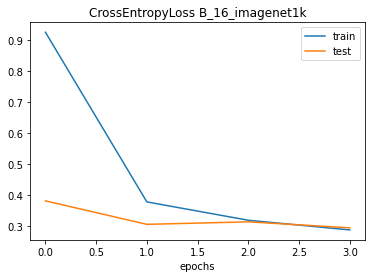

NameError: name 'Test_correct' is not defined

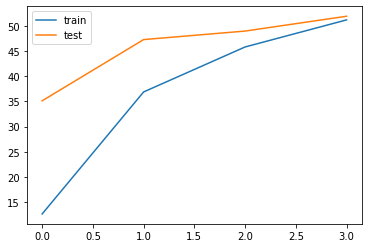

In [10]:
amp_db=transforms.AmplitudeToDB().to(device)
bs=5
normalize_spec_db, all_spectro, trainloader, testloader=init_param(model,train_index,test_index,data,bs,label_dic)

transform_train_db = T.Compose([amp_db, normalize_spec_db,
         # transforms.TimeStretch(fixed_rate =1.2),
        #transforms.TimeMasking(time_mask_param=20),
        #transforms.FrequencyMasking(freq_mask_param=30),
        #T.RandomHorizontalFlip(),
        #T.Resize((image_size,image_size))
         ])

transform_test_db = T.Compose([amp_db,           
        normalize_spec_db])

torch.cuda.empty_cache()
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0)


epochs=2

model.fit(epochs,optimizer,device,trainloader,all_spectro,max_lr=1e-5)

# draft

In [11]:
amp_db=transforms.AmplitudeToDB().to(device)
# index = 1
bs=2
normalize_spec_db, all_spectro, trainloader, testloader=init_param(model,train_index,test_index,data,bs,label_dic)


transform_train_db = T.Compose([amp_db, normalize_spec_db,
         # transforms.TimeStretch(fixed_rate =1.2),
        #transforms.TimeMasking(time_mask_param=20),
        #transforms.FrequencyMasking(freq_mask_param=30),
        #T.RandomHorizontalFlip(),
        #T.Resize((image_size,image_size))
         ])
transform_test_db = T.Compose([amp_db,           
        normalize_spec_db])

torch.cuda.empty_cache()
criterion = nn.CrossEntropyLoss()
grad_clip = 0.2
weight_decay = 1e-6
#post_transf=nn.Sequential(nn.Linear(21843,512),nn.ReLU(),nn.Linear(512,8)).to(device)
# TRY
# post_transf=nn.Sequential(nn.Linear(768,512),nn.ReLU(),nn.Linear(512,8)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0)
epochs=20
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-10, steps_per_epoch=len(trainloader), epochs=epochs)

Train_loss=[]
Test_loss=[]
Train_correct=[]
Test_correct=[]

In [16]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
    def forward(self, input):
        return input * torch.tanh(F.softplus(input))

TO TRY:
   - raw input in one or all layer 
   - every transformer layer
   - more complex feature extractor like spectrogram

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

# draft for google cloud computing v100

In [47]:
all_model_pretrained=['B_16', 'B_32', 'L_32', 'B_16_imagenet1k', 'B_32_imagenet1k', 'L_16_imagenet1k', 'L_32_imagenet1k']

In [47]:
criterion = nn.CrossEntropyLoss()
grad_clip = 0.2
amp_db=transforms.AmplitudeToDB().to(device)

# weight_decay = 1e-6
for model_name in all_model_pretrained:
    torch.cuda.empty_cache()
    #init model
    model = ViT(model_name, pretrained=False).to(device)
    dim_out=PRETRAINED_MODELS[model_name]["config"]["dim"]

    normalize_spec_db, all_spectro, trainloader, testloader=init_param(model)

    transform_train_db = T.Compose([ amp_db,     
                                    normalize_spec_db,])

    transform_test_db = T.Compose([amp_db,           
            normalize_spec_db])

    model.fc=nn.Sequential(nn.Linear(dim_out, 1024),nn.ReLU(),nn.Linear(1024, 8)).to(device)
    normal_ViT=Normal_ViT(model).to(device)
    optimizer = optim.Adam(normal_ViT.parameters(), lr=0.001,weight_decay=0)
    #init list
    Train_loss=[]
    Test_loss=[]
    Train_correct=[]
    Test_correct=[]
    best_model=45
    epochs=2
    normal_ViT.freeze()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-5, steps_per_epoch=len(trainloader), epochs=epochs)
    for epoch in range(1, epochs + 1):
        if epoch==2:
            normal_ViT.unfreeze()
        train_loss,correct_train=train_transf(model, device, trainloader, criterion, optimizer, epoch,scheduler,all_spectro,transform_train_db=transform_train_db,log_interval=100,grad_clip=grad_clip,Use_waveform=False)
        test_loss,correct_test=test_transf(model, device, testloader,criterion,all_spectro,transform_test_db,Use_waveform=False)
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Train_correct.append(correct_train)
        Test_correct.append(correct_test)
        print("lr = ",optimizer.param_groups[0]['lr'])
        if correct_test>best_model:
            best_model=correct_test
            path="model_save/Normal_ViT_"+model_name+"_spec.pth"
            torch.save(model.state_dict(), path)
    plt.plot(Train_loss)
    plt.plot(Test_loss)
    plt.legend(["train","test"])
    plt.title("CrossEntropyLoss "+model_name)
    plt.xlabel("epochs")
    plt.savefig('loss_'+model_name+' _spectro_all_spectr.png')
    plt.show()
                                                


224


NameError: name 'train_transf' is not defined